In [2]:
#Imports
import tensorflow as tf
import csv
from collections import OrderedDict
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import os
from sklearn.preprocessing import StandardScaler
from skimage.util import numpy_pad
from skimage import transform
from sklearn.model_selection import train_test_split
import time
import pickle
import sys
import six

#for python 2 and 3 compatibility
import future        # pip install future
#import six           # pip install six
from __future__ import print_function
%matplotlib inline


In [2]:
## check tensorflow version and presence of gpu
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

#Check python version
assert sys.version_info[0] ==2 and sys.version_info[1]==7, "Please use Python 2.7 (and not Python 3)"
print("Python {}.{}.{}".format(sys.version_info[0],sys.version_info[1],sys.version_info[2]))

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))



Python 2.7.13
TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


All four files are binary and include a 512 byte header followed by the file's data. 
The header mostly contains technical scan parameters and is largely identical across all images. 
With the exception of the field 'data_scale_factor', we do not expect information from the header to be necessary or useful for the competition task. 

```
File starts with 512 bytes (256 unint16) header, then the rest is unint16.
Data file order: AYX (angle, vertical axis, horizontal axis)
Axis Name, Stride, Number of samples, Axis Length
XAxis, 1, Nx=512, Lx=1.0 meters
YAxis, 512, Ny=660, Ly=2.0955 meters
Angular, 337920, Na=16, La=360-degrees
The data type of this file is 16bit unsigned integer.
```

## get image data

In [2]:
#I placed the data folder in the same directory as the notebook
img_paths = glob.glob('./data/aps/*.aps')

In [3]:
def read_header(infile):
    """Read image header (first 512 bytes)
    """
    h = dict()
    try:
        fid = open(infile, 'r+b')
    except IOError:
        return None
        
    h['filename'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 20))
    h['parent_filename'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 20))
    h['comments1'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 80))
    h['comments2'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 80))
    h['energy_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['config_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['file_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['trans_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['scan_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['data_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['date_modified'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 16))
    h['frequency'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['mat_velocity'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['num_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
    h['num_polarization_channels'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['spare00'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['adc_min_voltage'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['adc_max_voltage'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['band_width'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['spare01'] = np.fromfile(fid, dtype = np.int16, count = 5)
    h['polarization_type'] = np.fromfile(fid, dtype = np.int16, count = 4)
    h['record_header_size'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['word_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['word_precision'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['min_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['max_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['avg_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['data_scale_factor'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['data_units'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['surf_removal'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['edge_weighting'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['x_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['y_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['z_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['t_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['spare02'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['x_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['scan_orientation'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['scan_direction'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['data_storage_order'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['scanner_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['x_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['t_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['num_x_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
    h['num_y_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
    h['num_z_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
    h['num_t_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
    h['x_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['x_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['x_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['x_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['date_processed'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 8))
    h['time_processed'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 8))
    h['depth_recon'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['x_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['elevation_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['roll_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['azimuth_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['adc_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['spare06'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['scanner_radius'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['x_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['t_delay'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['range_gate_start'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['range_gate_end'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['ahis_software_version'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['spare_end'] = np.fromfile(fid, dtype = np.float32, count = 10)
    return h

In [4]:
def read_data(infile):
    """Read any of the 4 types of image files, returns a numpy array of the image contents
    """
    extension = os.path.splitext(infile)[1]

    h = read_header(infile)
    if h == None:
        return None
    nx = int(h['num_x_pts'])
    ny = int(h['num_y_pts'])
    nt = int(h['num_t_pts'])
    fid = open(infile, 'rb')
    #if file doesn't exist, return None
    try:
        fid = open(infile, 'r+b')
    except IOError:
        return None
    
    fid.seek(512) #skip header
    if extension == '.aps' or extension == '.a3daps':
        if(h['word_type']==7): #float32
            data = np.fromfile(fid, dtype = np.float32, count = nx * ny * nt)
        elif(h['word_type']==4): #uint16
            data = np.fromfile(fid, dtype = np.uint16, count = nx * ny * nt)
        data = data * h['data_scale_factor'] #scaling factor
        """
        nx, ny, nt, order F gives us 512 (width) x 660 (height) x 16 (angle)
        then rotate that 90 degrees to make it 660 x 512 x 16
        
        #data = data.reshape(nx, ny, nt, order='F').copy() #make N-d image
        #data = np.rot90(data,k=1)
        
        Other option, to get angle as the first dimension:
        nt, ny, nx order C gives 16 x 660 x 512; it's upside down, so flip it
        #data = data.reshape(nt, ny, nx, order='C').copy() #make N-d image
        #data = np.flip(data,axis=1)
        """
        data = data.reshape(nt, ny, nx, order='C').copy() #make N-d image
        data = np.flip(data,axis=1)
        
    elif extension == '.a3d':
        if(h['word_type']==7): #float32
            data = np.fromfile(fid, dtype = np.float32, count = nx * ny * nt)
        elif(h['word_type']==4): #uint16
            data = np.fromfile(fid, dtype = np.uint16, count = nx * ny * nt)
        data = data * h['data_scale_factor'] #scaling factor
        data = data.reshape(nx, nt, ny, order='F').copy() #make N-d image
    elif extension == '.ahi':
        data = np.fromfile(fid, dtype = np.float32, count = 2* nx * ny * nt)
        data = data.reshape(2, ny, nx, nt, order='F').copy()
        real = data[0,:,:,:].copy()
        imag = data[1,:,:,:].copy()
    fid.close()
    if extension != '.ahi':
        return data
    else:
        return real, imag

### pad image to make it square, then resize to match the required size of pre-trained network

In [5]:
def resize(img, height=224, width=224):
    """
    img: original angle 16, height 660, width 512
    height: desired height
    width: desired width
    
    First pads the shorter side with zeros, then resizes the square image.
    Since we pad with zeros, resize should be done before rescaling to between -0.5 and 0.5
    return: square resized image (16 angles by 224 height by 224 width)
    """
    angle, height0, width0 = img.shape
    pad_angle = (0,0)
    
    if height0 == width0:
        return img
    elif height0 > width0:
        pad_height = (0,0)
        diff = height0-width0
        pad_left = diff // 2
        pad_right = diff - pad_left
        pad_width = (pad_left,pad_right)
        pad = (pad_angle, pad_height, pad_width)
    else:
        pad_width = (0,0)
        diff = width0 - height0
        pad_up = diff // 2
        pad_down = diff - pad_up
        pad_height = (pad_up,pad_down)
        pad = (pad_angle, pad_height, pad_width)
        
    constant_values = ((0,0),(0,0),(0,0))
    img_square = numpy_pad(img, pad_width=pad, mode='constant', constant_values=constant_values)
    img_resized = transform.resize(img_square, (angle, 224, 224), mode='constant')
    
    #also duplicate to convert from single channel to rgb channel
        
    return img_resized

In [6]:
def rescale(img,out_left=0,out_right=1.0):
    '''
    img: angle x height x width
    returns: image with min value set out_left and max to out_right
    
    Since we're feeding this into vgg, it expects values between 0 and 1,
    and multiplies by 255.
    '''
    in_left = float(np.min(img))
    in_right = float(np.max(img))
    out_left = float(out_left)
    out_right = float(out_right)
    new_img = (img - in_left) * (out_right - out_left) / (in_right - in_left) + out_left
    return new_img

### get path to image file and the value of its labels

In [7]:
def get_xy(labels_file='./data/labels/stage1_labels.csv', n_zones=17, pre_path='./data/aps/', file_ext='.aps'):
    """
    One row for each unique file name; we'll see each file name
    multiple times (17 times, one for each body region), so I'll use a dictionary

    I'll have 17 columns, one for each region. It will either contain
    0 or 1.

    Note that it's not really one-hot encoding; I'll be predicting probabilities,
    and each region should be independent of each other, so I have to be careful
    about the activation function.  Softmax makes all outputs sum to 1.
    If I use a linear activation, then it's more like logistic regression; it
    should output a number between 0 and 1
    
    returns:
    image_paths: list of paths to the image files
    target_zone_arr: 2D np array of labels, each row is for one 
    """
    labels_d = OrderedDict()
    with open(labels_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        header = next(reader)
        for row in reader:
            name_zone = row[0]
            img_name, zone = name_zone.split('_')
            if img_name in labels_d:
                zone_prob = labels_d[img_name]
            else:
                zone_prob = np.zeros(n_zones, dtype=np.float32)
                labels_d[img_name] = zone_prob
            """
            zone looks like 'Zone13'; split it and convert number to int
            zone_prob is a list of 17 elements, one for each body zone;
            the values are the probabilities (0 or 1) that a threat exists on that region
            """
            zone_int = int(zone.split('Zone')[1])
            prob_int = float(row[1])
            zone_prob[zone_int-1] = prob_int

    """
    put the image file names into an ordered list
    combine the zone and probabilities into an np array
    """
    image_paths = []

    #create a dummy row so that I can concatenate all rows
    #since vgg returns codes that are ndarrays of float32, I'll make the targets also float32
    target_zone_arr = np.zeros((1,n_zones), dtype=np.float32)
    for img_name, target_zone in labels_d.items():
        image_paths.append(pre_path + img_name + file_ext)
        target_zone_arr = np.concatenate( [target_zone_arr,np.reshape(target_zone,(1,-1))], axis=0)
    #remove the first dummy row
    target_zone_arr = target_zone_arr[1:,:]
    
    #make sure the target_zone_arr is float32 and not float64
    target_zone_arr = target_zone_arr.astype(np.float32)
    return image_paths, target_zone_arr, labels_d

In [8]:
"""
image_paths
Get paths to the image files, 
Looks like: './data/aps/00360f79fd6e02781457eda48f85da90.aps'

target_zone_arr
Get 2D array of the target labels (rows are for each image, columns are for each of 17 angles)
Looks like:
array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.])
        
labels_d
Get an ordered dictionary (same order as the 2D numpy array of target labels)
where key is the file name without the directory or the file extension; 
the value is the numpy array of the targets
key: 00360f79fd6e02781457eda48f85da90
value: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                      1.,  0.,  0.,  0.]))

"""

image_paths, target_zone_arr, labels_d = get_xy(labels_file='./data/labels/stage1_labels.csv', 
                                                n_zones=17, 
                                                pre_path='./data/aps/',
                                                file_ext='.aps')

In [9]:
"""
Also get the test submission data

Note that we just want the image_paths_test; the probabilities are all 0.5
in this file, and we want to make our predictions on these test samples after training.

Test submission has 100 samples
"""
image_paths_test, target_zone_arr_test, labels_d_test = get_xy(labels_file='./data/labels/stage1_sample_submission.csv',
                                                               n_zones=17,
                                                               pre_path='./data/aps/',
                                                               file_ext='.aps')

## read image files in batches

In [10]:
VGG_HEIGHT = 224
VGG_WIDTH = 224

def yield_batch(img_paths, y, batch_size=10):
    """
    Given the list of files (already split into training set, and randomized)
    read in a batch of images and yield.
    
    returns:
        x_batch: batch_size x angles (16) x height x width
        y_batch: batch_size x num of regions (17)
    """
    num_records = len(y)
    img_l = []
    y_l = []
    b_ii = 1
    
    for ii in range(0, num_records):
        img = read_data(img_paths[ii])
        if img is None:
            continue
        #reshape to fit the size for pretrained model
        img = resize(img,height=VGG_HEIGHT,width=VGG_WIDTH)
        img = rescale(img)
        img_l.append(img)
        y_l.append(y[ii])
        
        '''
        If we have a full batch, then yield batch
        Or if we've seen all data points, yield what we have as the last batch
        Also reset the image and y lists
        '''
        if (b_ii % batch_size == 0):
            x_batch = np.array(img_l)
            y_batch = np.array(y_l)
            img_l = []
            y_l = []
            yield x_batch, y_batch
        b_ii +=1 #count actual available images in batch
        
    #yield once more for anything left over that isn't a full batch
    if len(img_l) > 0:
        x_batch = np.array(img_l)
        y_batch = np.array(y_l)
        yield x_batch,y_batch


How to use the yield function: use a for loop (it's an iterator)


```
batch_i = 0
for x_batch, y_batch in yield_batch(image_paths_test, y_test, batch_size=10):
    print(batch_i)
    print(x_batch.shape)
    print(y_batch.shape)
    batch_i +=1
```

## Explore images

In [14]:
x_batch, y_batch = next(yield_batch(image_paths, target_zone_arr, batch_size=16))

In [15]:
zone_names = ['right upper arm',
              'right forearm',
              'left upper arm',
              'left forearm',
              'chest',
              'right waist',
              'left waist',
              'right hip',
              'groin',
              'left hip',
              'right thigh',
              'left thigh',
              'right calf',
              'left calf',
              'right foot',
              'left foot',
              'upper back']    

In [16]:
from itertools import compress
for ii, obs in enumerate(y_batch):
    obs_bool = obs.astype(np.int32).astype(bool).tolist()
    threat_zones = list(compress(zone_names, obs_bool))
    print("sample ", str(ii+1), " threat zones: " + ", ".join(threat_zones))

sample  1  threat zones: left calf
sample  2  threat zones: right upper arm, groin, left calf
sample  3  threat zones: left forearm, right hip, left foot
sample  4  threat zones: left upper arm
sample  5  threat zones: right foot
sample  6  threat zones: right forearm
sample  7  threat zones: groin, right thigh, right calf
sample  8  threat zones: right upper arm, left calf
sample  9  threat zones: left forearm, left foot
sample  10  threat zones: right hip
sample  11  threat zones: left waist
sample  12  threat zones: right upper arm, left waist, left thigh
sample  13  threat zones: right calf
sample  14  threat zones: right upper arm, right hip
sample  15  threat zones: left waist
sample  16  threat zones: chest, left foot


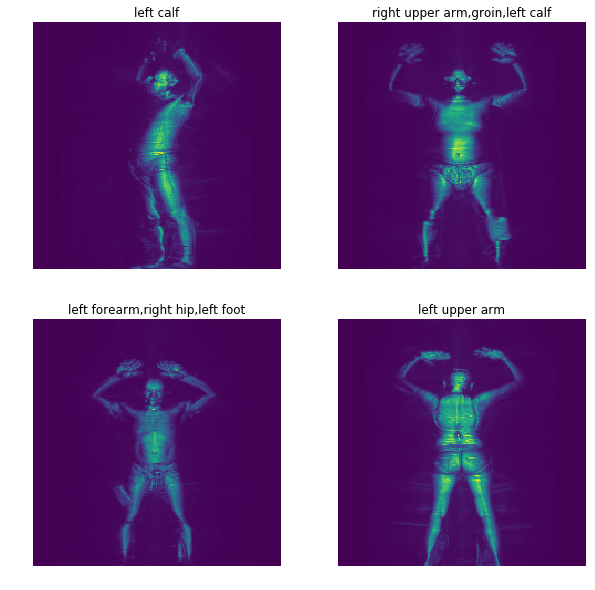

In [62]:
plt.rcParams['figure.figsize'] = (10, 10) #width, height
#for ii in range(4):

ii, angle = 0, 3
plt.subplot(2,2,ii+1);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle = 1, 0
plt.subplot(2,2,ii+1);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle =2, 0
plt.subplot(2,2,ii+1);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle = 3, 8
plt.subplot(2,2,ii+1);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');
plt.savefig('input_images_01_to_04.jpg')

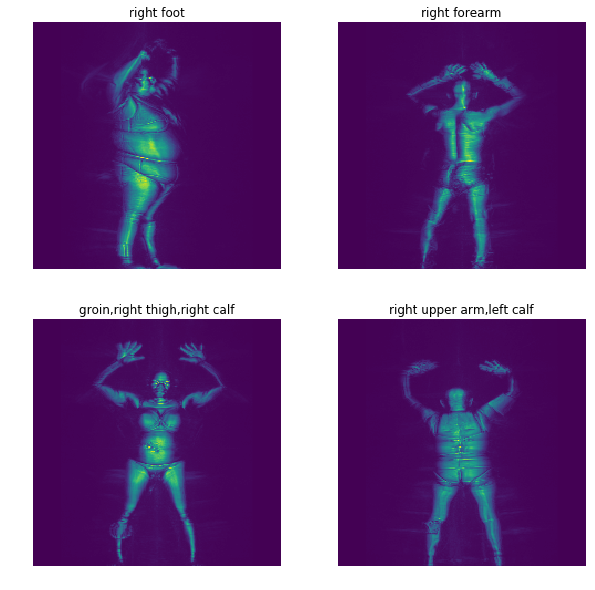

In [63]:
plt.rcParams['figure.figsize'] = (10, 10) #width, height
ii, angle = 4, 13
plt.subplot(2,2,1);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle = 5, 9
plt.subplot(2,2,2);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle =6, 0
plt.subplot(2,2,3);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle = 7, 8
plt.subplot(2,2,4);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');
plt.savefig('input_images_05_to_08.jpg')

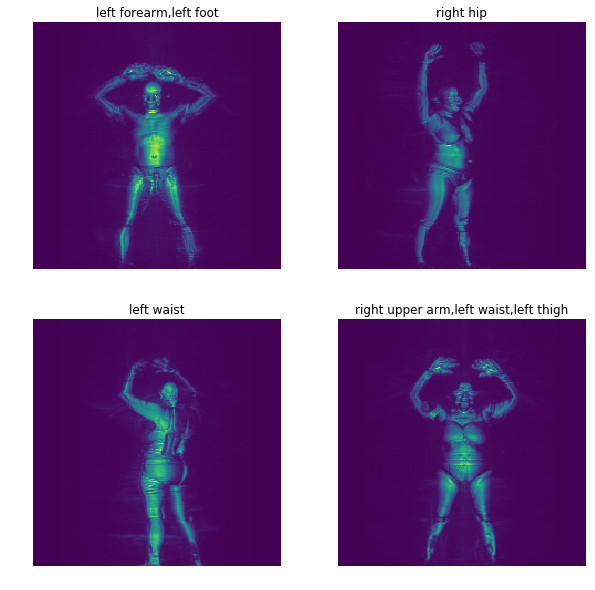

In [65]:
plt.rcParams['figure.figsize'] = (10, 10) #width, height

ii, angle = 8, 0
plt.subplot(2,2,1);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle = 9, 14
plt.subplot(2,2,2);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle =10, 6
plt.subplot(2,2,3);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle = 11, 0
plt.subplot(2,2,4);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');
plt.savefig('input_images_09_to_12.jpg')

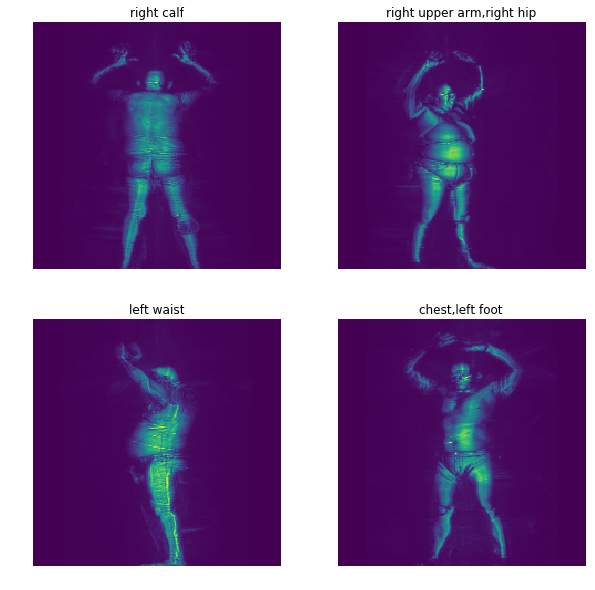

In [66]:
plt.rcParams['figure.figsize'] = (10, 10) #width, height
ii, angle = 12, 8
plt.subplot(2,2,1);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle = 13, 14
plt.subplot(2,2,2);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle =14, 4
plt.subplot(2,2,3);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');

ii, angle = 15, 1
plt.subplot(2,2,4);
plt.imshow(x_batch[ii][angle]);
obs = y_batch[ii]
obs_bool = obs.astype(np.int32).astype(bool).tolist()
threat_zones = list(compress(zone_names, obs_bool));
plt.title(",".join(threat_zones));
plt.axis('off');
plt.savefig('input_images_13_to_16.jpg')

In [54]:
from itertools import compress
for ii, obs in enumerate(y_batch):
    obs_bool = obs.astype(np.int32).astype(bool).tolist()
    threat_zones = list(compress(zone_names, obs_bool))
    print("sample ", str(ii+1), " threat zones: " + ", ".join(threat_zones))

sample  1  threat zones: left calf
sample  2  threat zones: right upper arm, groin, left calf
sample  3  threat zones: left forearm, right hip, left foot
sample  4  threat zones: left upper arm
sample  5  threat zones: right foot
sample  6  threat zones: right forearm
sample  7  threat zones: groin, right thigh, right calf
sample  8  threat zones: right upper arm, left calf
sample  9  threat zones: left forearm, left foot
sample  10  threat zones: right hip
sample  11  threat zones: left waist
sample  12  threat zones: right upper arm, left waist, left thigh
sample  13  threat zones: right calf
sample  14  threat zones: right upper arm, right hip
sample  15  threat zones: left waist
sample  16  threat zones: chest, left foot


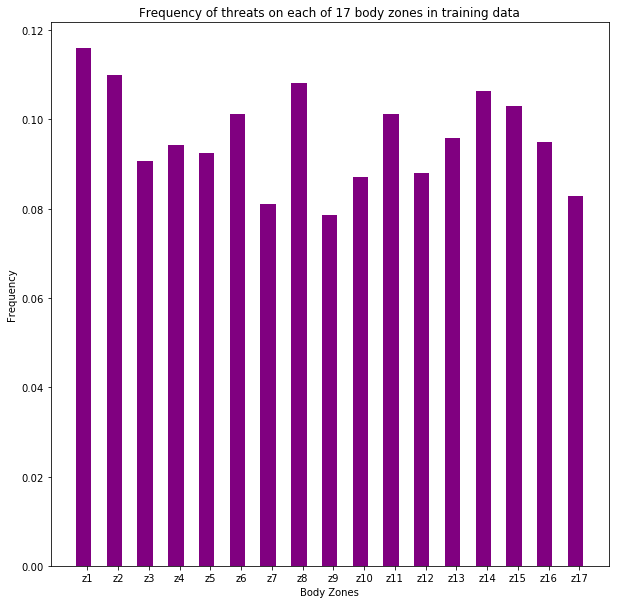

In [67]:
"""
Plot distribution of threat objects for each body zone
"""
target_sum = np.sum(target_zone_arr, axis=0)
target_mean = np.mean(target_zone_arr, axis=0)
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, target_mean, width_bars, color='purple');
ax.set_title("Frequency of threats on each of 17 body zones in training data");
ax.set_ylabel('Frequency')
ax.set_xlabel('Body Zones')
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);
plt.savefig("frequency_of_threats_by_body_zone.jpg")

In [60]:
print("frequency of threats for each body zone ranges from {:.3f} to {:.3f}, with an average of {:.3f}".format(np.min(target_mean), np.max(target_mean), np.mean(target_mean)))

frequency of threats for each body zone ranges from 0.078 to 0.116, with an average of 0.096


In [11]:
def angle_1c_to_3c(x_batch,angle,height,width,out_channel=3):
    """
    Each record in a batch includes all 16 angles; VGG will only look at one angle at a time
    From a x_batch of shape 
    batch_size x angles x height x width

    Choose a specific angle (0 to 15) and return
    batch_size x height x width x 3 (for rgb)

    x_batch: batch_size x angles (16) x height x width (1 channel)
    angle: desired angle to take for all images in the batch
    height: of in and out image
    width; of in and out image
    out_channel: take a 1 channel input and make it multiple channels (like 3 for red-green-blue)
    
    returns:
        angle_batch_3c: batch_size x height x width x out_channel
        
    sample use:
    angle_batch_3c = angle_1c_to_3c(x_batch,angle=14,height=VGG_HEIGHT,width=VGG_WIDTH,out_channel=3)
    """
    angle_batch = x_batch[:,angle,:,:]
    angle_batch_3c = None
    for ii in range(angle_batch.shape[0]):
        img1c = angle_batch[ii,:,:].reshape(VGG_HEIGHT,VGG_WIDTH,1)
        img3c = np.concatenate([img1c,img1c,img1c],axis=2).reshape(1,VGG_HEIGHT,VGG_WIDTH,out_channel)
        if angle_batch_3c is None:
            angle_batch_3c = img3c
        else:
            angle_batch_3c = np.concatenate([angle_batch_3c, img3c])

    return angle_batch_3c

## Use VGG for transfer learning
Clone the VGG repository in the same directory as the notebook
Note that there is a bug in the direct tensorflow-vgg github, so it won't work if I clone from here [https://github.com/machrisaa/tensorflow-vgg.git]

I can clone the udacity deep-learning library [https://github.com/udacity/deep-learning.git] and then copy the deep-learning/transfer-learning/tensorflow_vgg
folder to the same parent folder of this notebook, then it will work.

Need to install urllib3 package to use urllib

python 2 uses urllib
python 3 splits urllib into urllib.request and urllib.error

Also install tqdm
```
conda install tqdm
```

In [13]:
"""
Download pre-trained weights and biases, found in vgg16.npy
"""
#from urllib.request import urlretrieve #for python 3
from urllib import urlretrieve #for python 2
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = './tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file for vgg16.npy already exists!")

Parameter file for vgg16.npy already exists!


In [15]:
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils
import time
def get_codes_vgg(image_paths, y, batch_size=10):
    angles=16
    codes_by_angle = [None] * angles #each element represents a specific angle (0 to 15), and is of size batch x h x w x depth (5th convolutional layer)
    labels = []
    batch = []
    batch_i = 0
    n_img = 0
    tf.reset_default_graph()
    start_time = time.time()
    with tf.Session() as sess:
        vgg = vgg16.Vgg16()
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope("content_vgg"):
            vgg.build(input_)           
            for x_batch, y_batch in yield_batch(image_paths, y, batch_size):
                for angle in range(angles):
                    #grab one angle for all batches, convert 1 channel to 3 channel images
                    angle_batch_3c = angle_1c_to_3c(x_batch,angle=angle,height=VGG_HEIGHT,width=VGG_WIDTH)
                    #vgg16.conv5_3 layer is of size (batch, 14, 14, 512); pool5 i of size (batch, 7, 7, 512)
                    #vgg16.conv5_2 layer #worse than conv5_3
                    #codes_batch is ndarray with float32 values
                    feed_dict = {input_: angle_batch_3c}
                    codes_batch = sess.run(vgg.conv5_3, feed_dict=feed_dict)

                    if codes_by_angle[angle] is None:
                        codes_by_angle[angle] = codes_batch
                    else:
                        codes_by_angle[angle] = np.concatenate((codes_by_angle[angle], codes_batch))

                batch_i +=1
                n_img += x_batch.shape[0]     
                print("batch ", batch_i, " image count ", n_img, " elapsed time {:.2f} m".format((time.time() - start_time)/60))

    n_batch,height,width,channel = codes_by_angle[0].shape
    codes_by_angle_arr = codes_by_angle[0].reshape(1,n_batch,height,width,channel)
    for angle in range(1,angles):
        codes_by_angle_arr = np.concatenate([codes_by_angle_arr, codes_by_angle[angle].reshape(1,n_batch,height,width,channel)])

    """
    right now, angle is the outermost dimension (axis 0), and batch is axis 1
    make the batch the outer-most dimension, followed by angle, height, width, depth
    """
    codes_by_angle_arr = np.transpose(codes_by_angle_arr, axes=[1,0,2,3,4])
    return codes_by_angle_arr

In [15]:
"""
Run the entire data set (don't divide into train/test set yet) through vgg,
get the output of conv5 layer (before pooling), and save to disk
1147 total images
"""
codes_by_angle_arr = get_codes_vgg(image_paths, target_zone_arr, batch_size=10)

# write codes to file
with open('code_vgg16_conv5_3', 'w') as f:
    codes_by_angle_arr.tofile(f)
    
with open('target_vgg16_conv5_3', 'w') as f:
    target_zone_arr.tofile(f)

/home/edwardshyu/capstone/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
batch  1  image count  10  elapsed time 0.16 m
batch  2  image count  20  elapsed time 0.26 m
batch  3  image count  30  elapsed time 0.36 m
batch  4  image count  40  elapsed time 0.46 m
batch  5  image count  50  elapsed time 0.56 m
batch  6  image count  60  elapsed time 0.66 m
batch  7  image count  70  elapsed time 0.76 m
batch  8  image count  80  elapsed time 0.86 m
batch  9  image count  90  elapsed time 0.96 m
batch  10  image count  100  elapsed time 1.06 m
batch  11  image count  110  elapsed time 1.16 m
batch  12  image count  120  elapsed time 1.27 m
batch  13  image count  130  elapsed time 1.37 m
batch  14  image count  140  elapsed time 1.47 m
batch  15  image count  150  elapsed time 1.57 m
batch  16  image count  160  elapsed time 1.67 m
batch  17  image count  170  elapsed time 1.77 m
batch  18  image count  180  elapsed time 1.87 m
batch  19  image count  

In [16]:
"""
Get codes for the test images as well. We don't actually need the targets given in the submission file,
as they're all 0.5
"""
codes_by_angle_arr_test = get_codes_vgg(image_paths_test, target_zone_arr_test, batch_size=10)

# write codes to file
with open('code_test_vgg16_conv5_3', 'w') as f:
    codes_by_angle_arr_test.tofile(f)
    
#with open('target_test', 'w') as f:
#    target_zone_arr_test.tofile(f)

/home/edwardshyu/capstone/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
batch  1  image count  10  elapsed time 0.13 m
batch  2  image count  20  elapsed time 0.23 m
batch  3  image count  30  elapsed time 0.33 m
batch  4  image count  40  elapsed time 0.43 m
batch  5  image count  50  elapsed time 0.53 m
batch  6  image count  60  elapsed time 0.63 m
batch  7  image count  70  elapsed time 0.73 m
batch  8  image count  80  elapsed time 0.83 m
batch  9  image count  90  elapsed time 0.93 m
batch  10  image count  100  elapsed time 1.02 m


# load output of pretrained network

In [3]:
#angles x records x height x width x channel depth
angles = 16
n_obs = 1147
height = 14
width = 14
depth = 512
regions = 17

with open('./code_vgg16_conv5_3') as f:
    code = np.fromfile(f, dtype=np.float32)
    
with open('./target_vgg16_conv5_3') as f:
    target = np.fromfile(f, dtype=np.float32)
    
code = code.reshape([n_obs,angles,height,width,depth])
target = target.reshape([n_obs, regions])

In [149]:
"""
codes dimensions are: batch x angles x height x width, x depth
"""
print("code shape", code.shape)
print("target shape", target.shape)

code shape (1147, 16, 14, 14, 512)
target shape (1147, 17)


In [4]:
""" 
Also loads codes of test output data
"""
angles = 16
n_obs = 100
height = 14
width = 14
depth = 512
regions = 17

with open('./code_test_vgg16_conv5_3') as f:
    code_test = np.fromfile(f, dtype=np.float32)
    
#with open('target_test') as f:
#    target_test = np.fromfile(f, dtype=np.float32)
    
code_test = code_test.reshape([n_obs,angles,height,width,depth])

"""
codes dimensions are: batch x angles x height x width, x depth
"""
print("code_test shape", code_test.shape)

code_test shape (100, 16, 14, 14, 512)


## split into training, validation and test

#### Note, please run the cell Option 1 or Option 2, but each overrides the other

In [5]:
"""
Option 1 with more training data

split into training and validation data
I'm using test size of 17.4% so that the test and validation each have 100 observations.
The test submission sample is 100 observations long.
"""
x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(code,
                                                                     target,
                                                                     range(target.shape[0]),
                                                                     test_size=0.174,
                                                                     random_state=0)

half_len = len(y_test)//2
x_valid, y_valid = x_test[:half_len], y_test[:half_len]
x_test, y_test = x_test[half_len:], y_test[half_len:]

print("Train shapes (x, y):", x_train.shape, y_train.shape)
print("Validation shapes (x, y):", x_valid.shape, y_valid.shape)
print("Test shapes (x, y):", x_test.shape, y_test.shape)

Train shapes (x, y): (947, 16, 14, 14, 512) (947, 17)
Validation shapes (x, y): (100, 16, 14, 14, 512) (100, 17)
Test shapes (x, y): (100, 16, 14, 14, 512) (100, 17)


In [5]:
"""
Option 2 for more test data

for testing and output of results, reserve more data for testing, and leave out validation
"""
"""
split into training and validation data
I'm using test size of 17.4% so that the test and validation each have 100 observations.
The test submission sample is 100 observations long.
"""
x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(code,
                                                                     target,
                                                                     range(target.shape[0]),
                                                                     test_size=0.27,
                                                                     random_state=0)

valid_len = 10
x_valid, y_valid = x_test[:valid_len], y_test[:valid_len]
x_test, y_test = x_test[valid_len:], y_test[valid_len:]

print("Train shapes (x, y):", x_train.shape, y_train.shape)
print("Validation shapes (x, y):", x_valid.shape, y_valid.shape)
print("Test shapes (x, y):", x_test.shape, y_test.shape)

Train shapes (x, y): (837, 16, 14, 14, 512) (837, 17)
Validation shapes (x, y): (10, 16, 14, 14, 512) (10, 17)
Test shapes (x, y): (300, 16, 14, 14, 512) (300, 17)


# Network components

## Inputs

In [6]:
def get_inputs(code_shape, target_shape):
    input_ = tf.placeholder(tf.float32,
                             shape=[None, code_shape[1], code_shape[2], code_shape[3], code_shape[4]],
                             name="input")
    
    target_ = tf.placeholder(tf.float32,
                              shape=[None, target_shape[1]],
                              name="target")
    
    keep_prob_ = tf.placeholder(tf.float32, name='keep_prob')
    
    is_training_ = tf.placeholder(tf.bool, name="is_training")
    
    return input_, target_, keep_prob_, is_training_

In [54]:
"""
verify get_inputs
"""
tf.reset_default_graph()
code_shape = (917, 16, 14, 14, 512)
target_shape = (917, 17)
#just for local machine without data
#input_, target_, keep_prob_, is_training_ = get_inputs(code_shape, target_shape)
input_, target_, keep_prob_, is_training_ = get_inputs(code.shape, target.shape)

print("input_:",input_)
print("target_:",target_)
print("keep_prob_:",keep_prob_)
print("is_training_:",is_training_)

input_: Tensor("input:0", shape=(?, 16, 14, 14, 512), dtype=float32)
target_: Tensor("target:0", shape=(?, 17), dtype=float32)
keep_prob_: Tensor("keep_prob:0", dtype=float32)
is_training_: Tensor("is_training:0", dtype=bool)


In [7]:
def leaky_relu(x,name,alpha=0.2):
    relu = tf.maximum(alpha * x, x)
    relu = tf.identity(relu, name)
    return relu

Tensorflow Padding

SAME Padding, the output height and width are computed as:
```
out_height = ceil(float(in_height) / float(strides[1]))

out_width = ceil(float(in_width) / float(strides[2]))
```

VALID Padding, the output height and width are computed as:

```
out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))

out_width = ceil(float(in_width - filter_width + 1) / float(strides[2]))
```

## multiview convolutions that reuse weights

In [8]:
def multiview_layers(views, keep_prob=0.5, is_training=True, print_details=False):
    """
    views are inputs, with dimensions: batch x angles x width x height x channels
    
    I'll get out of memory if allocating a tensor of 64 batches by 6x6x2048; I'll stick with 1024 max depth
    """
    n_views = views.get_shape().as_list()[1]  #16 views (angles)

    # transpose views : (NxVxWxHxC) -> (VxNxWxHxC)
    views = tf.transpose(views, perm=[1, 0, 2, 3, 4])
    
    view_features = []

    for i in xrange(n_views):
        reuse = (i != 0) #reuse is False for the 0th angle, and true for all remaining angles
        view = tf.gather(views, i) # batch x W x H x C

        with tf.variable_scope(name_or_scope='multiview', reuse=reuse) as scope:
            conv1 = tf.layers.conv2d(view, filters=1024, kernel_size=3, strides=2, padding='same',reuse=reuse,name='conv1')
            bn1 = tf.layers.batch_normalization(conv1, training=is_training,reuse=reuse,name='bn1')
            relu1 = leaky_relu(bn1, name='relu1')
            drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob, name='drop1')
            
            #flatten last conv layer into 2D: batch x (width*height*channels)
            dim = np.prod(drop1.get_shape().as_list()[1:])
            flat = tf.reshape(drop1, [-1, dim],name='flat')
            view_features.append(flat)
            
            if print_details:
                if i in [0, 15]: #just sample some angles to verify tensors
                    print("view i: ", i)
                    print("conv1: ", conv1)
                    print("bn1: ", bn1)
                    print("relu1:", relu1)
                    print("drop1: ", drop1)

                    print("flat: ",flat)
        
    return view_features

In [104]:
"""
verify multiview_layers
"""
tf.reset_default_graph()
code_shape = (917, 16, 14, 14, 512)
target_shape = (917, 17)
#just for local machine without data
input_, target_, keep_prob_, is_training_ = get_inputs(code_shape, target_shape)

view_features_layer = multiview_layers(views=input_, keep_prob=0.5, is_training=True, print_details=True)

view i:  0
conv1:  Tensor("multiview/conv1/BiasAdd:0", shape=(?, 7, 7, 1024), dtype=float32)
bn1:  Tensor("multiview/bn1/batchnorm/add_1:0", shape=(?, 7, 7, 1024), dtype=float32)
relu1: Tensor("multiview/relu1:0", shape=(?, 7, 7, 1024), dtype=float32)
drop1:  Tensor("multiview/drop1/mul:0", shape=(?, 7, 7, 1024), dtype=float32)
flat:  Tensor("multiview/flat:0", shape=(?, 50176), dtype=float32)
view i:  15
conv1:  Tensor("multiview_15/conv1/BiasAdd:0", shape=(?, 7, 7, 1024), dtype=float32)
bn1:  Tensor("multiview_15/bn1/batchnorm/add_1:0", shape=(?, 7, 7, 1024), dtype=float32)
relu1: Tensor("multiview_15/relu1:0", shape=(?, 7, 7, 1024), dtype=float32)
drop1:  Tensor("multiview_15/drop1/mul:0", shape=(?, 7, 7, 1024), dtype=float32)
flat:  Tensor("multiview_15/flat:0", shape=(?, 50176), dtype=float32)


In [9]:
def view_pool(view_features_layer, name='view_pool8'):
    '''
    Combines the list of view features using maximum, into one
    "view" of the same dimensions as a single view.
    
    This adds an extra dimension in front of the other dimensions;
    So when we use reduce max, this extra dimension disappears
    and the result is a matrix with the same dimensions as
    each of the view matrices, and is an aggregate (max) 
    of all of them;

    It gets the 0th view outside of the loop just so it
    has something to concatenate with the 1st view

    gets the maximum for each index within the view
    
    '''
    view_pool_layer = tf.expand_dims(view_features_layer[0], 0)
    for view in view_features_layer[1:]:
        view = tf.expand_dims(view, 0)
        view_pool_layer = tf.concat([view_pool_layer, view], 0)
    
    view_pool_layer = tf.reduce_max(view_pool_layer, [0], name=name)
    return view_pool_layer

In [32]:
"""
Verify 
"""
view_pool_layer = view_pool(view_features_layer, name='view_pool')
view_pool_layer

<tf.Tensor 'view_pool:0' shape=(?, 4096) dtype=float32>

In [10]:
def dense(view_pool_layer, keep_prob=0.5, is_training=True, n_target=17):
    dense1 = tf.layers.dense(view_pool_layer, units=2048, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    dense2 = tf.layers.dense(drop1, units=512, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')
   
    '''
    Output should have 17 units, one for each body region
    Use sigmoid so that each unit ranges from 0 to 1, independently of the other units
    '''
    logits = tf.layers.dense(drop2, units=n_target, name='logits')
    output = tf.sigmoid(logits,name='output')
    
    return output

In [34]:
"""
verify dense layer
"""
output = dense(view_pool_layer, keep_prob=0.5, is_training=True, n_target=17)
output

<tf.Tensor 'output:0' shape=(?, 17) dtype=float32>

In [11]:
"""
loss function, use reduce_mean (mean squared error)

Kaggle uses log loss function:

"""
def get_loss(output, target):
    loss = tf.losses.log_loss(labels=target,predictions=output)
    loss = tf.identity(loss, name='loss')
    return loss

In [36]:
loss_tmp = get_loss(output, target)
loss_tmp

<tf.Tensor 'loss:0' shape=() dtype=float32>

In [12]:
def get_optimizer(loss, learning_rate, beta1=0.5):
    """
    param beta1: The exponential decay rate for the 1st moment in the optimizer
    
    use control dependencies so that batch normalization works properly during inference
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss)

    """
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss)
    return opt

In [13]:
"""
accuracy

compare targets_ with output

if targets_ is 1, then output is correct when it's 0.5 or above
if targets_ is 0, then output is correct when it's <0.5
"""
def get_accuracy(output,target):
    diff = tf.subtract(target, output)
    abs_diff = tf.abs(diff)
    diff_is_less = tf.less(abs_diff, 0.5)
    diff_is_less_float = tf.cast(diff_is_less, tf.float32)
    accuracy = tf.reduce_mean(diff_is_less_float, name="accuracy")
    return accuracy

In [14]:
"""
get batches

"""
def get_code_target_batch(x, y, batch_size=64):
    n_obs = y.shape[0]
    n_batches = target.shape[0]//batch_size
    for ii in range(0, n_obs, batch_size):
        x_batch = x[ii:ii+batch_size]
        y_batch = y[ii:ii+batch_size]
        yield x_batch,y_batch

In [53]:
"""
verify batches function
"""
"""
batch_i = 0
for x_train_batch, y_train_batch in get_code_target_batch(x_train, y_train, batch_size=64):
    batch_i +=1
    print("batch ", batch_i)
    print("x_train_batch.shape", x_train_batch.shape)
    print("y_train_batch.shape",y_train_batch.shape)
"""

'\nbatch_i = 0\nfor x_train_batch, y_train_batch in get_code_target_batch(x_train, y_train, batch_size=64):\n    batch_i +=1\n    print("batch ", batch_i)\n    print("x_train_batch.shape", x_train_batch.shape)\n    print("y_train_batch.shape",y_train_batch.shape)\n'

In [15]:
"""
Train network (for each batch)
"""
def train(session, opt, keep_prob, input_batch, target_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    feed = {input_ : input_batch,
            target_ : target_batch,
            keep_prob_ : keep_prob,
            is_training_ : True
           }
    session.run(opt, feed_dict=feed)
    pass

In [16]:
"""
track training and validation losses
"""
def print_stats(session, x_train_batch, y_train_batch, x_valid, y_valid, loss, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # training loss
    train_loss_dict = {input_: x_train_batch, 
                       target_: y_train_batch,
                       keep_prob_ : 1.,
                       is_training_ : False
                      }
    train_loss, train_accuracy = session.run([loss, accuracy], feed_dict=train_loss_dict)

    #validation loss
    valid_loss_dict = {input_: x_valid,
                       target_: y_valid,
                       keep_prob_ : 1.,
                       is_training_ : False
                      }
    valid_loss, valid_accuracy = session.run([loss, accuracy], feed_dict=valid_loss_dict)
        
    #end while loop
    print("train loss {:.4f}, valid loss {:.4f}; train acc {:.4f}, valid acc {:.4f}".format(train_loss, valid_loss, train_accuracy, valid_accuracy))
    return train_loss, valid_loss

In [17]:
"""
Build the network model
"""

"""
hyper parameters
"""
LEARNING_RATE=0.0001
BETA1=0.5
epochs=20
BATCH_SIZE=64
KEEP_PROB = 0.5

#reset graph
tf.reset_default_graph()

#inputs
#code_shape = (1147, 16, 14, 14, 512)
#target_shape = (1147, 17)
#input_, target_, keep_prob_, is_training_ = get_inputs(code_shape, target_shape) #for local machine without data

input_, target_, keep_prob_, is_training_ = get_inputs(code.shape, target.shape)

view_features_layer = multiview_layers(views=input_, keep_prob=keep_prob_, is_training=is_training_)

view_pool_layer = view_pool(view_features_layer=view_features_layer, name='view_pool')

output = dense(view_pool_layer=view_pool_layer, keep_prob=keep_prob_, is_training=is_training_, n_target=17)

loss = get_loss(output=output, target=target_)

accuracy = get_accuracy(output=output, target=target_)

opt = get_optimizer(loss=loss, learning_rate=LEARNING_RATE, beta1=BETA1)

## Train the model

In [19]:
"""
iterate through batches and train

"""

save_model_path = './saved_session'
start_time = time.time()

#save losses for each epoch 
train_loss_l = []
valid_loss_l = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        batch_i = 0
        for x_train_batch, y_train_batch in get_code_target_batch(x_train, y_train, batch_size=BATCH_SIZE):
            batch_i +=1
            print('Epoch {:>2}, batch {}, time {:.2f}m  '.format(epoch + 1, batch_i, (time.time()-start_time)/60), end='')
            train(session=sess, opt=opt, keep_prob=KEEP_PROB, input_batch=x_train_batch, target_batch=y_train_batch)
            train_loss, valid_loss = print_stats(session=sess, x_train_batch=x_train_batch, y_train_batch=y_train_batch, x_valid=x_valid, y_valid=y_valid, loss=loss, accuracy=accuracy)
            train_loss_l.append(train_loss)
            valid_loss_l.append(valid_loss)
            
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    

Epoch  1, batch 1, time 0.19m  train loss 1.8705, valid loss 2.0081; train acc 0.4605, valid acc 0.4576
Epoch  1, batch 2, time 0.35m  train loss 1.7895, valid loss 1.8039; train acc 0.4816, valid acc 0.4865
Epoch  1, batch 3, time 0.40m  train loss 1.6508, valid loss 1.7654; train acc 0.5294, valid acc 0.5029
Epoch  1, batch 4, time 0.44m  train loss 1.6761, valid loss 1.8265; train acc 0.5193, valid acc 0.4947
Epoch  1, batch 5, time 0.48m  train loss 1.7045, valid loss 1.7562; train acc 0.5028, valid acc 0.4918
Epoch  1, batch 6, time 0.52m  train loss 1.5361, valid loss 1.6175; train acc 0.4724, valid acc 0.4412
Epoch  1, batch 7, time 0.57m  train loss 1.4143, valid loss 1.4949; train acc 0.4504, valid acc 0.4376
Epoch  1, batch 8, time 0.61m  train loss 1.3630, valid loss 1.3570; train acc 0.4596, valid acc 0.4606
Epoch  1, batch 9, time 0.65m  train loss 1.2616, valid loss 1.2933; train acc 0.4807, valid acc 0.4712
Epoch  1, batch 10, time 0.70m  train loss 1.1995, valid loss 1.

In [20]:
"""
plot training and validation
"""
def plot_losses(title="Training and Validation Log Loss"):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.plot(range(0,len(train_loss_l)*BATCH_SIZE, BATCH_SIZE),
            train_loss_l,
            label='training loss'
           )

    ax.plot(range(0,len(valid_loss_l)*BATCH_SIZE, BATCH_SIZE),
            valid_loss_l,
            label='validation loss')

    ax.set_xlabel('Training steps')
    ax.set_ylabel('Log Loss')
    ax.set_title(title)
    ax.legend(loc=1)
    plt.grid(True)
    plt.show();

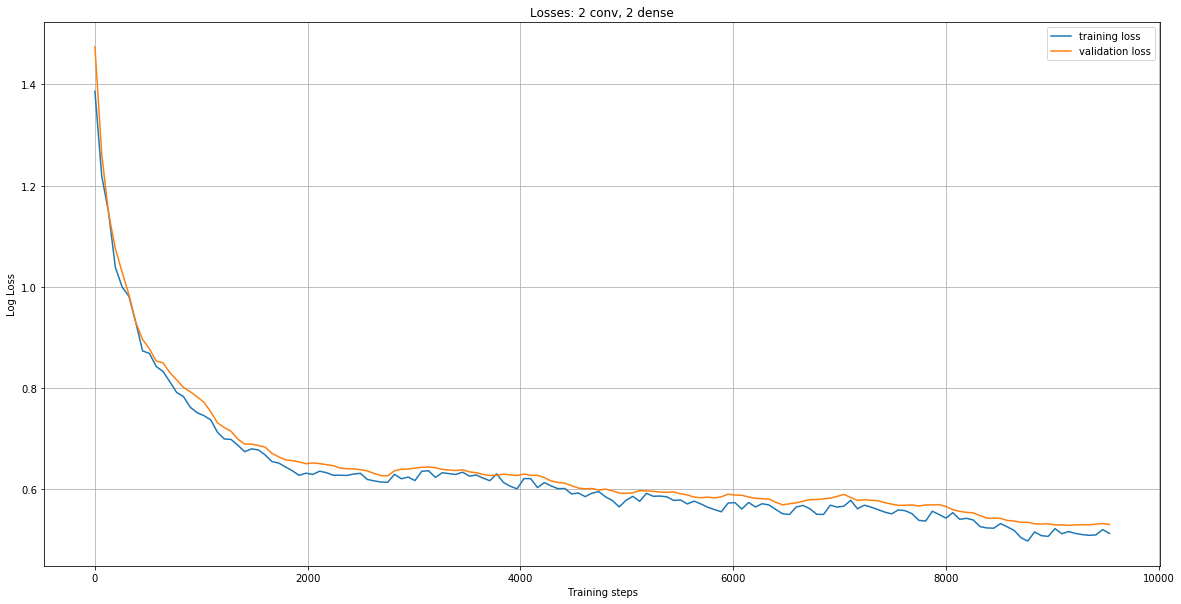

In [56]:
"""
Training results run 1
Epoch 10, batch 15, time 5.04m  train loss 0.5130, valid loss 0.5308; train acc 0.7809, valid acc 0.7641

Conclusion for next try:
Validation accuracy is following training closely, which is good; 
validation loss is not increasing, so I will try more epochs

Using vgg16 layer .conv5_3 to create codes

LEARNING_RATE=0.0001
BETA1=0.5
epochs=10
BATCH_SIZE=64
KEEP_PROB = 0.5

2 convolutional layers
    conv1 = tf.layers.conv2d(view, filters=512, kernel_size=3, strides=2, padding='valid',reuse=reuse,name='conv1')
    bn1 = tf.layers.batch_normalization(conv1, training=is_training,reuse=reuse,name='bn1')
    relu1 = leaky_relu(bn1, name='relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob, name='drop1')

    conv2 = tf.layers.conv2d(drop1, filters=1024, kernel_size=3, strides=2, padding='valid',reuse=reuse,name='conv2')
    bn2 = tf.layers.batch_normalization(conv2, training=is_training,reuse=reuse,name='bn2')
    relu2 = leaky_relu(bn2, name='relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob, name='drop2')

view_pool layer
    view_pool_layer = tf.reduce_max(view_pool_layer, [0], name=name)

2 dense layers
    dense1 = tf.layers.dense(view_pool_layer, units=1024, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    dense2 = tf.layers.dense(drop1, units=256, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')

"""
plot_losses(title="Losses: 2 conv, 2 dense")

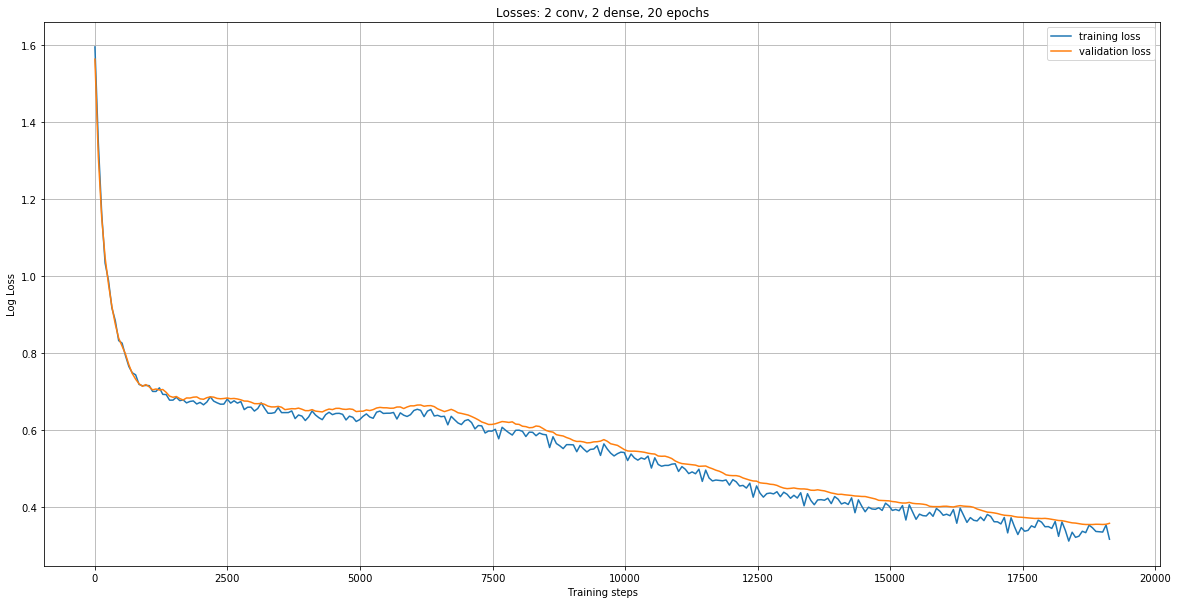

In [59]:
"""
Training results run 2
Epoch 20, batch 15, time 10.00m  train loss 0.3152, valid loss 0.3565; train acc 0.9043, valid acc 0.8912

Conclusion for next try:
Validation accuracy is following training closely, which is good; 
validation loss is not increasing, so I will try more epochs

Using vgg16 layer .conv5_3 to create codes

LEARNING_RATE=0.0001
BETA1=0.5
epochs=20
BATCH_SIZE=64
KEEP_PROB = 0.5

2 convolutional layers
    conv1 = tf.layers.conv2d(view, filters=512, kernel_size=3, strides=2, padding='valid',reuse=reuse,name='conv1')
    bn1 = tf.layers.batch_normalization(conv1, training=is_training,reuse=reuse,name='bn1')
    relu1 = leaky_relu(bn1, name='relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob, name='drop1')

    conv2 = tf.layers.conv2d(drop1, filters=1024, kernel_size=3, strides=2, padding='valid',reuse=reuse,name='conv2')
    bn2 = tf.layers.batch_normalization(conv2, training=is_training,reuse=reuse,name='bn2')
    relu2 = leaky_relu(bn2, name='relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob, name='drop2')

view_pool layer
    view_pool_layer = tf.reduce_max(view_pool_layer, [0], name=name)

2 dense layers
    dense1 = tf.layers.dense(view_pool_layer, units=1024, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    dense2 = tf.layers.dense(drop1, units=256, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')

"""
plot_losses(title="Losses: 2 conv, 2 dense, 20 epochs")

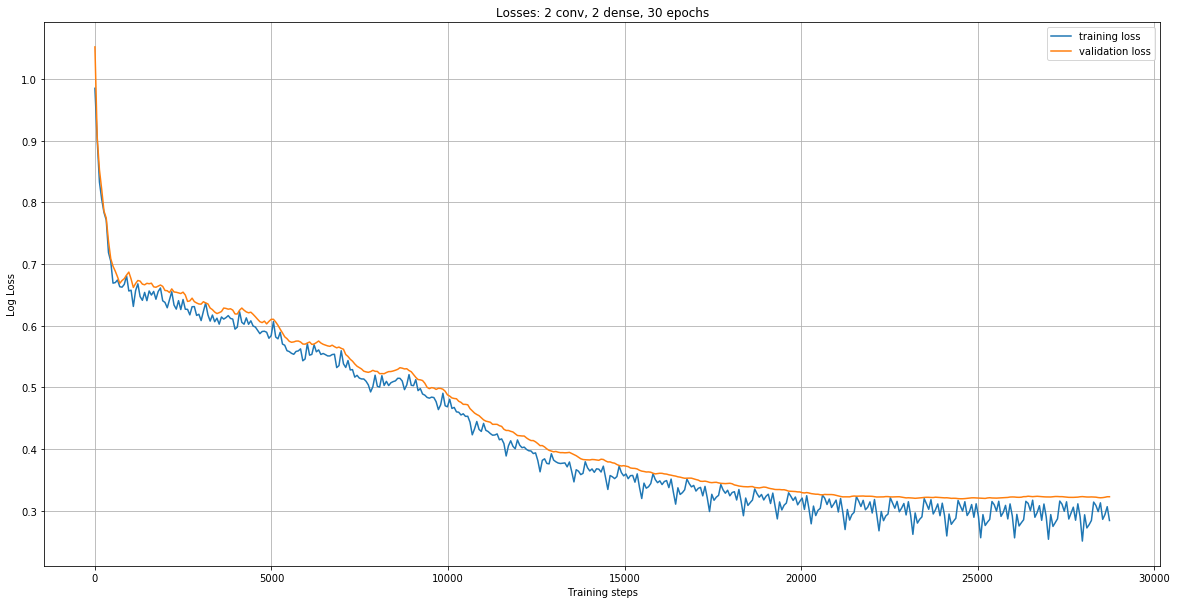

In [63]:
"""
Training results run 3
Epoch 30, batch 15, time 14.90m  train loss 0.2841, valid loss 0.3227; train acc 0.9020, valid acc 0.9047

Conclusion for next try:
Validation accuracy flattening at 0.32
Try changing the model.  Reduce strides from 2 to 1

Using vgg16 layer .conv5_3 to create codes

LEARNING_RATE=0.0001
BETA1=0.5
epochs=30
BATCH_SIZE=64
KEEP_PROB = 0.5

2 convolutional layers
    conv1 = tf.layers.conv2d(view, filters=512, kernel_size=3, strides=2, padding='valid',reuse=reuse,name='conv1')
    bn1 = tf.layers.batch_normalization(conv1, training=is_training,reuse=reuse,name='bn1')
    relu1 = leaky_relu(bn1, name='relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob, name='drop1')

    conv2 = tf.layers.conv2d(drop1, filters=1024, kernel_size=3, strides=2, padding='valid',reuse=reuse,name='conv2')
    bn2 = tf.layers.batch_normalization(conv2, training=is_training,reuse=reuse,name='bn2')
    relu2 = leaky_relu(bn2, name='relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob, name='drop2')

view_pool layer
    view_pool_layer = tf.reduce_max(view_pool_layer, [0], name=name)

2 dense layers
    dense1 = tf.layers.dense(view_pool_layer, units=1024, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    dense2 = tf.layers.dense(drop1, units=256, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')

"""
plot_losses(title="Losses: 2 conv, 2 dense, 30 epochs")

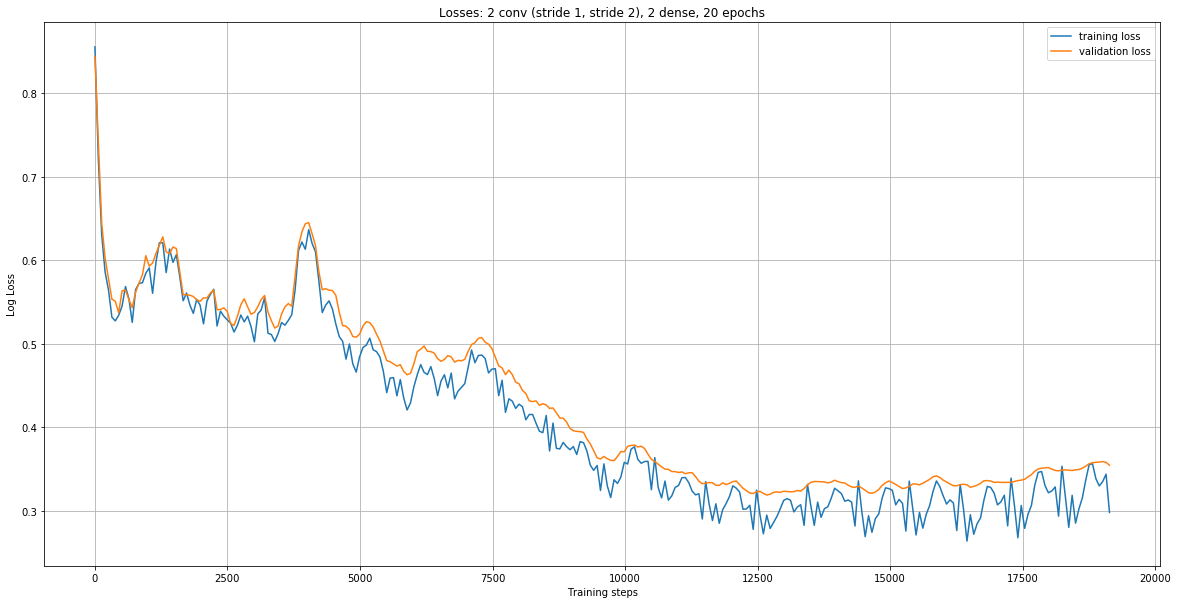

In [90]:
"""
Training results run 4
Using stride 1 for first conv layer (instead of 2)

Results: (best valid loss of .3274 at epoch 16, gets worse after more training)
Epoch 16, batch 15, time 14.61m  train loss 0.2758, valid loss 0.3274; train acc 0.9077, valid acc 0.9059
Also, the validation loss jumps up and down a lot more.

Conclusion for next try:
Stick with stride of 2, but try adding a 3rd convolutional layer to allow more space for learning features

Using vgg16 layer .conv5_3 to create codes

LEARNING_RATE=0.0001
BETA1=0.5
epochs=20
BATCH_SIZE=64
KEEP_PROB = 0.5

2 convolutional layers
    conv1 = tf.layers.conv2d(view, filters=512, kernel_size=3, strides=1, padding='valid',reuse=reuse,name='conv1')
    bn1 = tf.layers.batch_normalization(conv1, training=is_training,reuse=reuse,name='bn1')
    relu1 = leaky_relu(bn1, name='relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob, name='drop1')

    conv2 = tf.layers.conv2d(drop1, filters=1024, kernel_size=3, strides=2, padding='valid',reuse=reuse,name='conv2')
    bn2 = tf.layers.batch_normalization(conv2, training=is_training,reuse=reuse,name='bn2')
    relu2 = leaky_relu(bn2, name='relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob, name='drop2')

view_pool layer
    view_pool_layer = tf.reduce_max(view_pool_layer, [0], name=name)

2 dense layers
    dense1 = tf.layers.dense(view_pool_layer, units=1024, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    dense2 = tf.layers.dense(drop1, units=256, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')

"""
plot_losses(title="Losses: 2 conv (stride 1, stride 2), 2 dense, 20 epochs")

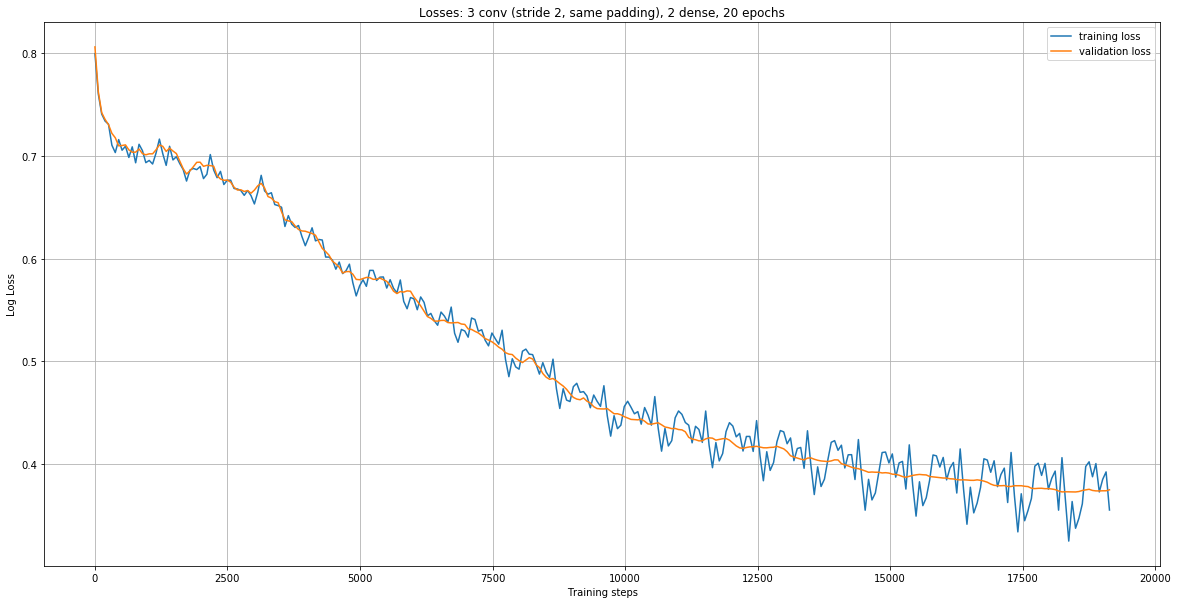

In [95]:
"""
Training results run 5
I added a 3rd conv layer.  In order to keep using strides of 2, I use 'same' padding, so that
the width/height don't shrink as quickly at each layer.  This way, I can add a 3rd conv layer.

Results: 
It gets valid loss .3206 at epoch 17, and starts getting worse after that.
Epoch 17, batch 15, time 14.06m  train loss 0.3082, valid loss 0.3206; train acc 0.9031, valid acc 0.9047

Conclusion for next try:
Adding a 3rd layer doesn't seem to help.  I'll try just one conv layer.

Using vgg16 layer .conv5_3 to create codes

LEARNING_RATE=0.0001
BETA1=0.5
epochs=20
BATCH_SIZE=64
KEEP_PROB = 0.5

3 convolutional layers
    conv1 = tf.layers.conv2d(view, filters=512, kernel_size=3, strides=2, padding='same',reuse=reuse,name='conv1')
    bn1 = tf.layers.batch_normalization(conv1, training=is_training,reuse=reuse,name='bn1')
    relu1 = leaky_relu(bn1, name='relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob, name='drop1')

    conv2 = tf.layers.conv2d(drop1, filters=750, kernel_size=3, strides=2, padding='same',reuse=reuse,name='conv2')
    bn2 = tf.layers.batch_normalization(conv2, training=is_training,reuse=reuse,name='bn2')
    relu2 = leaky_relu(bn2, name='relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob, name='drop2')

    conv3 = tf.layers.conv2d(drop2, filters=1024, kernel_size=3, strides=2, padding='same',reuse=reuse,name='conv3')
    bn3 = tf.layers.batch_normalization(conv3, training=is_training,reuse=reuse,name='bn3')
    relu3 = leaky_relu(bn3, name='relu3')
    drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob, name='drop3')

view_pool layer
    view_pool_layer = tf.reduce_max(view_pool_layer, [0], name=name)

2 dense layers
    dense1 = tf.layers.dense(view_pool_layer, units=1024, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    dense2 = tf.layers.dense(drop1, units=256, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')

"""
plot_losses(title="Losses: 3 conv (stride 2, same padding), 2 dense, 20 epochs")

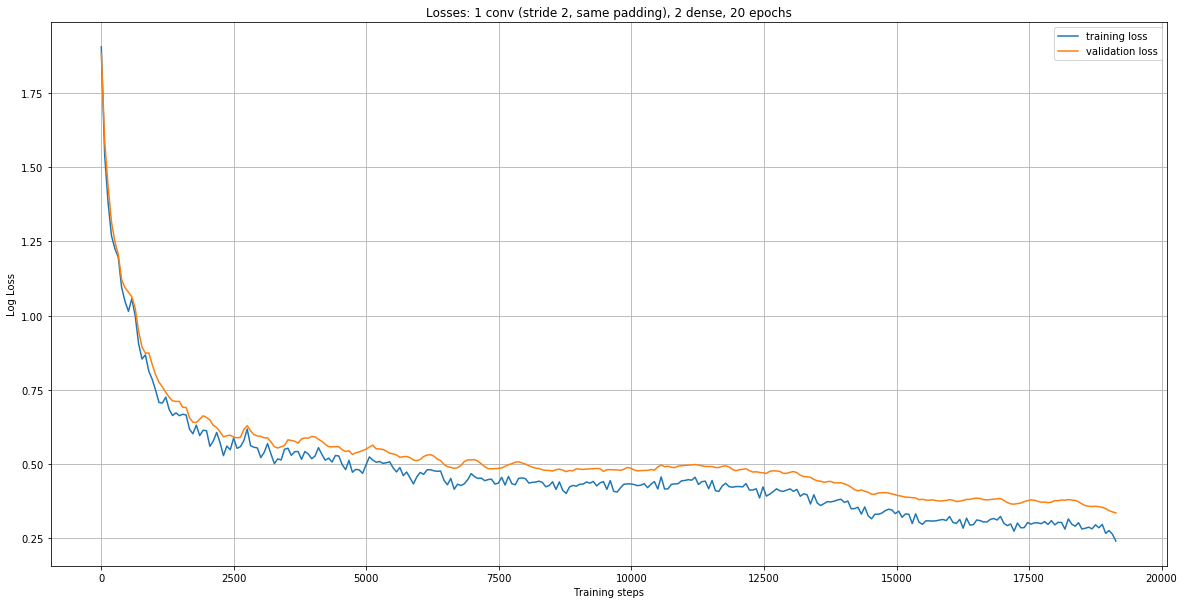

In [102]:
"""
Training results run 6
I use just 1 conv layer

Results: 
Epoch 20, batch 15, time 8.00m  train loss 0.2409, valid loss 0.3360; train acc 0.9689, valid acc 0.8912

Conclusion for next try:
I'll try increasing the channels of the one conv layer, so that it has more room to learn.

Using vgg16 layer .conv5_3 to create codes

LEARNING_RATE=0.0001
BETA1=0.5
epochs=20
BATCH_SIZE=64
KEEP_PROB = 0.5

3 convolutional layers
    conv1 = tf.layers.conv2d(view, filters=512, kernel_size=3, strides=2, padding='same',reuse=reuse,name='conv1')
    bn1 = tf.layers.batch_normalization(conv1, training=is_training,reuse=reuse,name='bn1')
    relu1 = leaky_relu(bn1, name='relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob, name='drop1')

view_pool layer
    view_pool_layer = tf.reduce_max(view_pool_layer, [0], name=name)

2 dense layers
    dense1 = tf.layers.dense(view_pool_layer, units=1024, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    dense2 = tf.layers.dense(drop1, units=256, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')

"""
plot_losses(title="Losses: 1 conv (stride 2, same padding), 2 dense, 20 epochs")

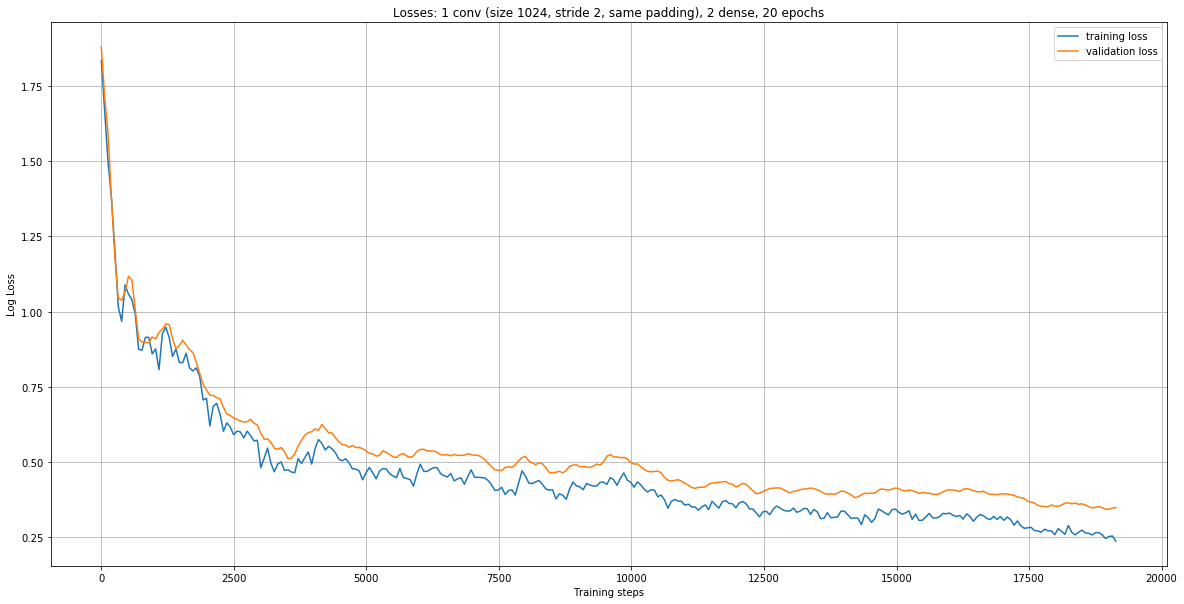

In [107]:

"""
Training results run 7
I use just 1 conv layer, size 1024 instead of 512.

Results: 
Epoch 20, batch 15, time 13.02m  train loss 0.2371, valid loss 0.3489; train acc 0.9769, valid acc 0.8976


Conclusion for next try:
I'll try increasing the units of the dense layers.  They're 1024 and then 256.  I'll try 2048 and then 512.

Using vgg16 layer .conv5_3 to create codes

LEARNING_RATE=0.0001
BETA1=0.5
epochs=20
BATCH_SIZE=64
KEEP_PROB = 0.5

3 convolutional layers
    conv1 = tf.layers.conv2d(view, filters=1024, kernel_size=3, strides=2, padding='same',reuse=reuse,name='conv1')
    bn1 = tf.layers.batch_normalization(conv1, training=is_training,reuse=reuse,name='bn1')
    relu1 = leaky_relu(bn1, name='relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob, name='drop1')

view_pool layer
    view_pool_layer = tf.reduce_max(view_pool_layer, [0], name=name)

2 dense layers
    dense1 = tf.layers.dense(view_pool_layer, units=1024, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    dense2 = tf.layers.dense(drop1, units=256, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')

"""
plot_losses(title="Losses: 1 conv (size 1024, stride 2, same padding), 2 dense, 20 epochs")

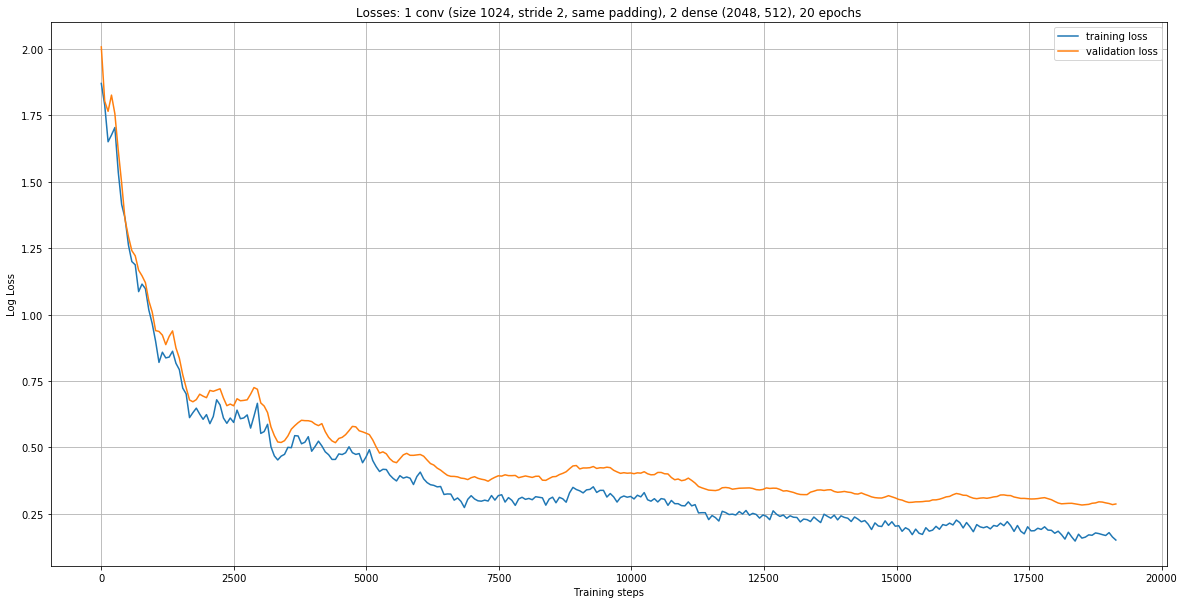

In [21]:
"""
Training results run 8
I use just 1 conv layer, size 1024;
dense layers are 2048 and 512 instead of 1024 and 256

Results: 
Got lowest loss at epoch 20
First run
Epoch 20, batch 15, time 13.16m  train loss 0.1488, valid loss 0.2898; train acc 0.9827, valid acc 0.9024

Second run has a similar final validation loss
Epoch 20, batch 15, time 13.11m  train loss 0.1507, valid loss 0.2865; train acc 0.9781, valid acc 0.9018


Conclusion for next try:

Using vgg16 layer .conv5_3 to create codes

LEARNING_RATE=0.0001
BETA1=0.5
epochs=20
BATCH_SIZE=64
KEEP_PROB = 0.5

3 convolutional layers
    conv1 = tf.layers.conv2d(view, filters=1024, kernel_size=3, strides=2, padding='same',reuse=reuse,name='conv1')
    bn1 = tf.layers.batch_normalization(conv1, training=is_training,reuse=reuse,name='bn1')
    relu1 = leaky_relu(bn1, name='relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob, name='drop1')

view_pool layer
    view_pool_layer = tf.reduce_max(view_pool_layer, [0], name=name)

2 dense layers
    dense1 = tf.layers.dense(view_pool_layer, units=2048, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    dense2 = tf.layers.dense(drop1, units=512, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')

"""
plot_losses(title="Losses: 1 conv (size 1024, stride 2, same padding), 2 dense (2048, 512), 20 epochs")

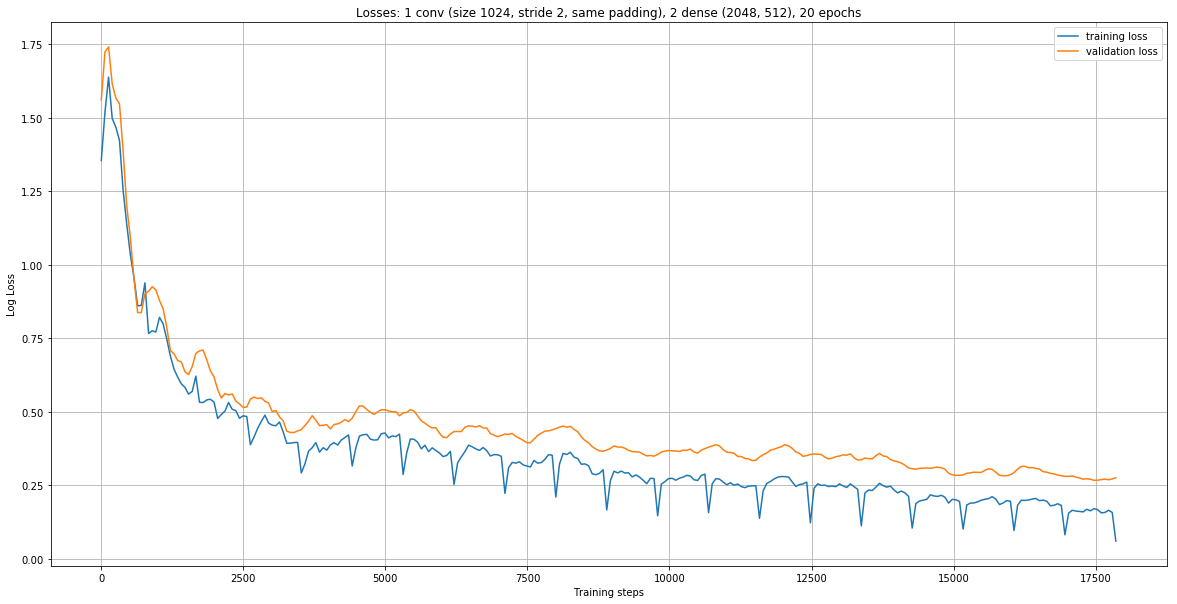

In [177]:
"""
Training results run 8b
To have more samples for test results, I split the data so there are 300 test samples instead of 100.

Train shapes (x, y): (837, 16, 14, 14, 512) (837, 17)
Validation shapes (x, y): (10, 16, 14, 14, 512) (10, 17)
Test shapes (x, y): (300, 16, 14, 14, 512) (300, 17)

I use just 1 conv layer, size 1024;
dense layers are 2048 and 512 instead of 1024 and 256

Results: 
Got lowest loss at epoch 19


Epoch 20, batch 15, time 13.16m  train loss 0.1488, valid loss 0.2898; train acc 0.9827, valid acc 0.9024

Conclusion for next try:

Using vgg16 layer .conv5_3 to create codes

LEARNING_RATE=0.0001
BETA1=0.5
epochs=20
BATCH_SIZE=64
KEEP_PROB = 0.5

3 convolutional layers
    conv1 = tf.layers.conv2d(view, filters=1024, kernel_size=3, strides=2, padding='same',reuse=reuse,name='conv1')
    bn1 = tf.layers.batch_normalization(conv1, training=is_training,reuse=reuse,name='bn1')
    relu1 = leaky_relu(bn1, name='relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob, name='drop1')

view_pool layer
    view_pool_layer = tf.reduce_max(view_pool_layer, [0], name=name)

2 dense layers
    dense1 = tf.layers.dense(view_pool_layer, units=2048, name='fc_dense1')
    bn1 = tf.layers.batch_normalization(dense1, training=is_training, name='fc_bn1')
    relu1 = leaky_relu(bn1,name='fc_relu1')
    drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob,name='fc_drop1')
    
    dense2 = tf.layers.dense(drop1, units=512, name='fc_dense2')
    bn2 = tf.layers.batch_normalization(dense2, training=is_training, name='fc_bn2')
    relu2 = leaky_relu(bn2,name='fc_relu2')
    drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob,name='fc_drop2')

"""
plot_losses(title="Losses: 1 conv (size 1024, stride 2, same padding), 2 dense (2048, 512), 20 epochs")

## predictions on the test sample

In [22]:
"""

"""
save_model_path = './saved_session'

loaded_graph = tf.Graph()

with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)
    
    # Get Tensors from loaded model
    loaded_input_ = loaded_graph.get_tensor_by_name('input:0')
    loaded_target_ = loaded_graph.get_tensor_by_name('target:0')
    loaded_keep_prob_ = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_is_training_ = loaded_graph.get_tensor_by_name('is_training:0')
    loaded_output = loaded_graph.get_tensor_by_name('output:0')
    loaded_loss = loaded_graph.get_tensor_by_name('loss:0')
    loaded_accuracy = loaded_graph.get_tensor_by_name('accuracy:0')

    test_feed = {
        loaded_input_ : x_test,
        loaded_target_ : y_test,
        loaded_keep_prob_ : 1.,
        loaded_is_training_ : False
    }
    
    test_loss, test_accuracy, test_output = sess.run([loaded_loss, loaded_accuracy, loaded_output], feed_dict=test_feed)
    
    print("test_loss: ", test_loss, " test_accuracy: ", test_accuracy)

INFO:tensorflow:Restoring parameters from ./saved_session
test_loss:  0.269204  test_accuracy:  0.914118


#### Test results
Test results with 100 test samples, 947 training samples, 100 validation samples

```
INFO:tensorflow:Restoring parameters from ./saved_session
test_loss:  0.269204 test_accuracy:  0.914118
```

#### Test results with 300 test samples
test results with 300 test samples, 847 training samples, 10 validation samples
```
INFO:tensorflow:Restoring parameters from ./saved_session
test_loss:  0.281498  test_accuracy:  0.906666
```

## Predictions on the test submission sample of 100
Output to a csv file and submit to kaggle

In [113]:
save_model_path = './saved_session'

loaded_graph = tf.Graph()

with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)
    
    # Get Tensors from loaded model
    loaded_input_ = loaded_graph.get_tensor_by_name('input:0')
    loaded_keep_prob_ = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_is_training_ = loaded_graph.get_tensor_by_name('is_training:0')
    loaded_output = loaded_graph.get_tensor_by_name('output:0')

    test_feed = {
        loaded_input_ : code_test,
        loaded_keep_prob_ : 1.,
        loaded_is_training_ : False
    }
    
    output = sess.run([loaded_output], feed_dict=test_feed)
    
    print("output predictions on test submission data:")
    print(output)

INFO:tensorflow:Restoring parameters from ./saved_session
output predictions on test submission data:
[array([[ 0.17890587,  0.2588686 ,  0.13178687, ...,  0.02934913,
         0.0513506 ,  0.20087872],
       [ 0.05398912,  0.41770113,  0.18546207, ...,  0.01916765,
         0.08225992,  0.1038049 ],
       [ 0.19833671,  0.22301207,  0.23202345, ...,  0.03402289,
         0.07951393,  0.08078361],
       ..., 
       [ 0.21798965,  0.2201259 ,  0.18853395, ...,  0.02593499,
         0.15442269,  0.19157441],
       [ 0.12393054,  0.31311956,  0.39531332, ...,  0.02982876,
         0.20194407,  0.10045089],
       [ 0.03317411,  0.29675156,  0.0794664 , ...,  0.05883472,
         0.49605373,  0.25916308]], dtype=float32)]


In [114]:
"""
Write results to csv file
"""

"""
img_name_l is a list of the file names
['0367394485447c1c3485359ba71f52cb',
 '0749d03b6d2d1eebb6c24ecb3c36e645',
 '08dc52d08482393070d8c71b11902636',
 '0a83698bce92a6824dcc37c1d7fc31f5',
 ...
"""
img_name_l = [ path.split('/')[-1].split('.')[0] for path in image_paths_test]
prediction = output[0]
"""
get the name, zone (index 1 to 17)
"""
with open('stage1_submission.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["Id","Probability"])
    for ii, name in enumerate(img_name_l):
        for zone in range(17):
            name_zone = name + "_Zone" + str(zone+1)
            probability = prediction[ii,zone]
            writer.writerow([name_zone,probability])

I submitted to kaggle, and got a test loss of  0.28421.

# Visualization to summarize project

In [14]:
"""
Count number of correct predictions for each body zone
Number of false positives
Number of false negatives

Also get average distance from 0 for non-threat regions
Get average distance from 1 for threat regions.

    diff = tf.subtract(target, output)
    abs_diff = tf.abs(diff)
    diff_is_less = tf.less(abs_diff, 0.5)
    diff_is_less_float = tf.cast(diff_is_less, tf.float32)
    accuracy = tf.reduce_mean(diff_is_less_float, name="accuracy")

"""
n_target_1 = np.zeros(shape=[17], dtype=np.int32) #number of samples with target of 1 (threat)
n_target_0 = np.zeros(shape=[17], dtype=np.int32) #number of samples with target of 0 (no threat)
n_true_pos = np.zeros(shape=[17], dtype=np.int32) #num of preds >= 0.5 when target is 1 (correctly predicts a threat)
n_true_neg = np.zeros(shape=[17], dtype=np.int32) #num of preds < 0.5 when  target is 0 (correctly predicts non-threat)
n_false_pos = np.zeros(shape=[17], dtype=np.int32) #num of preds >=0.5 when target is 0 (falsely predicts threat)
n_false_neg = np.zeros(shape=[17], dtype=np.int32) #num of preds <0.5 when target is 1 (falsely predicts no threat)

n_dist = np.zeros(shape=[17], dtype=np.float32)
n_dist_1 = np.zeros(shape=[17], dtype=np.float32) #distance from true target when true target is 1 (threat)
n_dist_0 = np.zeros(shape=[17], dtype=np.float32) #distance from true target when true target is 0 (non-threat)

In [15]:
for ss in range(y_test.shape[0]):
    for ii in range(y_test.shape[1]):
        y_target = y_test[ss][ii]
        pred = test_output[ss][ii]
        
        #if there is a threat:
        if y_target == 1:
            n_target_1[ii] +=1 #count threats for each body zone
            n_dist_1[ii] += y_target - pred #sum distance between pred and actual
            if pred >= 0.5:
                n_true_pos[ii] +=1
            else:
                n_false_neg[ii] +=1
                
        else:
            n_target_0[ii] +=1
            n_dist_0[ii] += pred - y_target
            if pred < 0.5:
                n_true_neg[ii] +=1
            else:
                n_false_pos[ii] +=1
                
        n_dist[ii] += np.abs(y_target - pred)

In [16]:
n_target_1 + n_target_0

array([300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300,
       300, 300, 300, 300], dtype=int32)

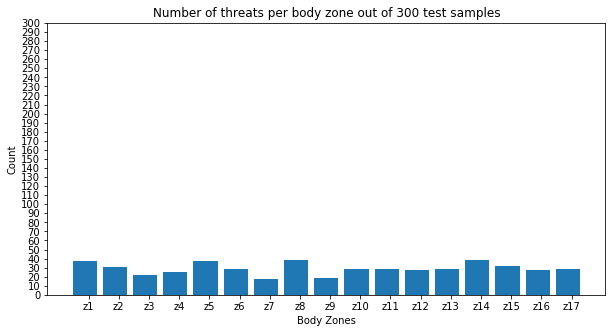

In [20]:
plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, n_target_1);
ax.set_title("Number of threats per body zone out of 300 test samples");
ax.set_ylabel('Count')
ax.set_xlabel('Body Zones')
ax.set_yticks(range(0,301,10))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);

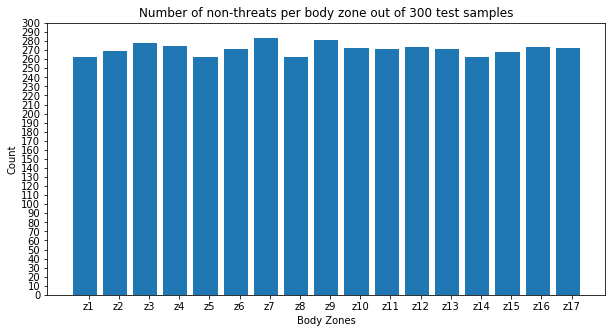

In [19]:
plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, n_target_0);
ax.set_title("Number of non-threats per body zone out of 300 test samples");
ax.set_ylabel('Count')
ax.set_xlabel('Body Zones')
ax.set_yticks(range(0,301,10))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);

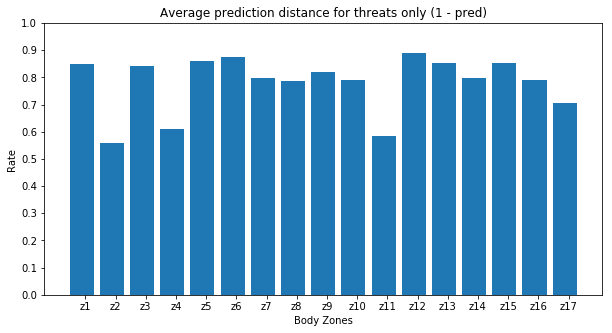

In [21]:
plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, n_dist_1 / n_target_1);
ax.set_title("Average prediction distance for threats only (1 - pred)");
ax.set_ylabel('Rate')
ax.set_xlabel('Body Zones')
ax.set_yticks(np.arange(0,1.01,.1))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);

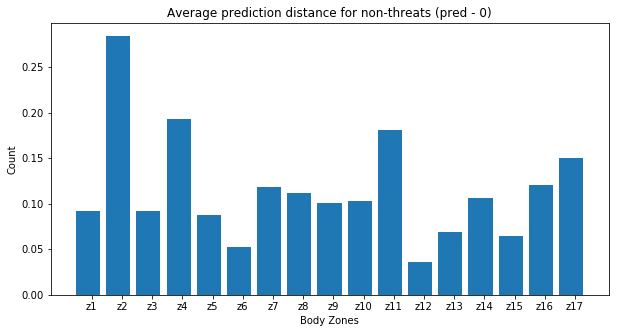

In [22]:
plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, n_dist_0 / n_target_0);
ax.set_title("Average prediction distance for non-threats (pred - 0)");
ax.set_ylabel('Count')
ax.set_xlabel('Body Zones')
#ax.set_yticks(np.arange(0,1.01,.1))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);

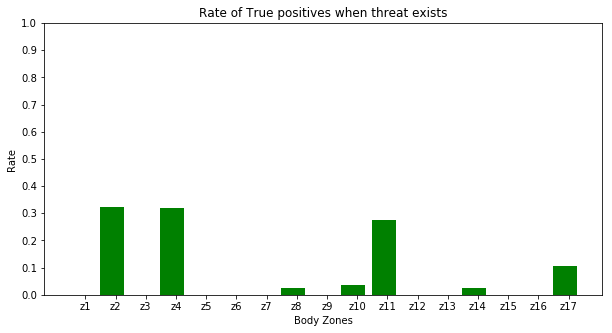

In [34]:
plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, n_true_pos.astype(np.float32) / n_target_1 ,color='green');
ax.set_title("Rate of True positives when threat exists");
ax.set_ylabel('Rate')
ax.set_xlabel('Body Zones')
ax.set_yticks(np.arange(0,1.01,.1))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);

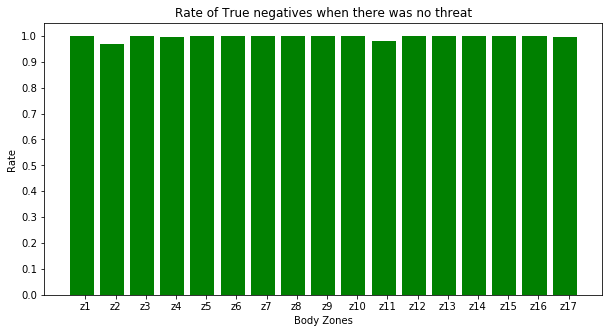

In [35]:
plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, n_true_neg.astype(np.float32) / n_target_0 , color='green');
ax.set_title("Rate of True negatives when there was no threat");
ax.set_ylabel('Rate')
ax.set_xlabel('Body Zones')
ax.set_yticks(np.arange(0,1.01,.1))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);

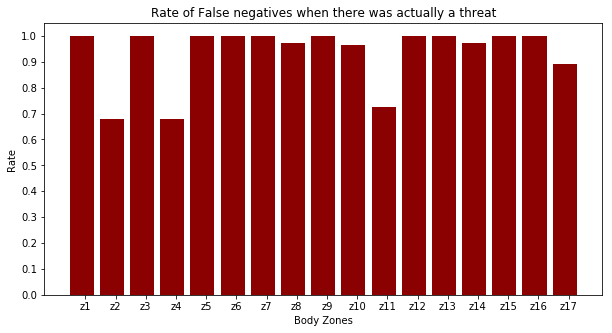

In [38]:
plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, n_false_neg.astype(np.float32) / n_target_1, color='darkred' );
ax.set_title("Rate of False negatives when there was actually a threat");
ax.set_ylabel('Rate')
ax.set_xlabel('Body Zones')
ax.set_yticks(np.arange(0,1.01,.1))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);

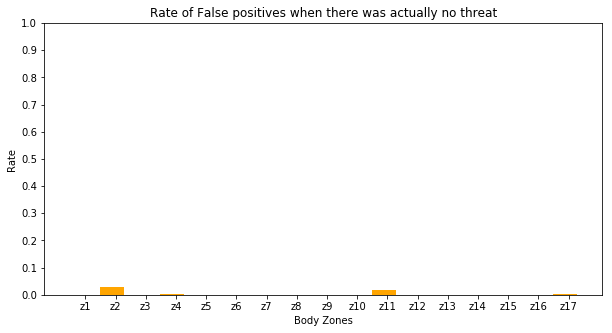

In [39]:
plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, n_false_pos.astype(np.float32) / n_target_0, color='orange' );
ax.set_title("Rate of False positives when there was actually no threat");
ax.set_ylabel('Rate')
ax.set_xlabel('Body Zones')
ax.set_yticks(np.arange(0,1.01,.1))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);

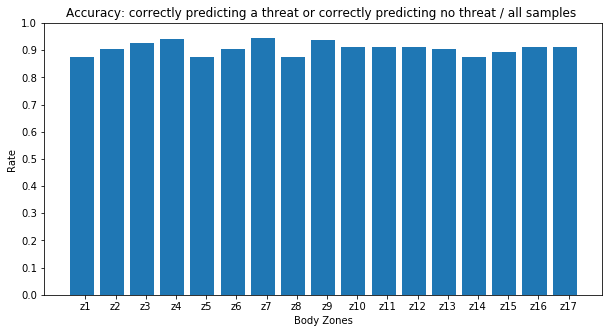

In [29]:
"""
accuracy: true positives + true negatives / all samples
"""
plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, (n_true_pos.astype(np.float32) + n_true_neg.astype(np.float32)) / 300);
ax.set_title("Accuracy: correctly predicting a threat or correctly predicting no threat / all samples ");
ax.set_ylabel('Rate')
ax.set_xlabel('Body Zones')
ax.set_yticks(np.arange(0,1.01,.1))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);

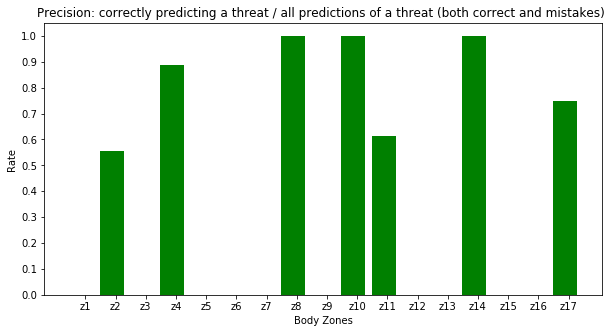

In [40]:
"""
precision = true positives / (true positives + false positives)
"""
precision = np.zeros(shape=(17), dtype=np.float32)
for ii in range(n_true_pos.shape[0]):
    denominator = n_true_pos[ii] + n_false_pos[ii]
    if denominator > 0:
        precision[ii] = n_true_pos[ii].astype(np.float32) / denominator
#precision


plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, precision, color='green');
ax.set_title("Precision: correctly predicting a threat / all predictions of a threat (both correct and mistakes) ");
ax.set_ylabel('Rate')
ax.set_xlabel('Body Zones')
ax.set_yticks(np.arange(0,1.01,.1))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);

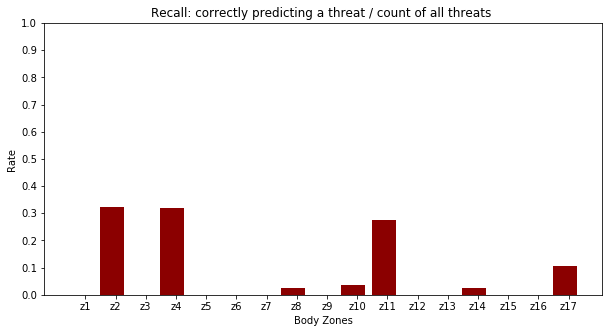

In [42]:
"""
recall: true positives / (true positives + false negatives)

"""
recall = np.zeros(shape=(17), dtype=np.float32)
for ii in range(n_true_pos.shape[0]):
    denominator = n_true_pos[ii] + n_false_neg[ii]
    if denominator > 0:
        recall[ii] = n_true_pos[ii].astype(np.float32) / denominator
        
plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, recall, color='darkred' );
ax.set_title("Recall: correctly predicting a threat / count of all threats ");
ax.set_ylabel('Rate')
ax.set_xlabel('Body Zones')
ax.set_yticks(np.arange(0,1.01,.1))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);


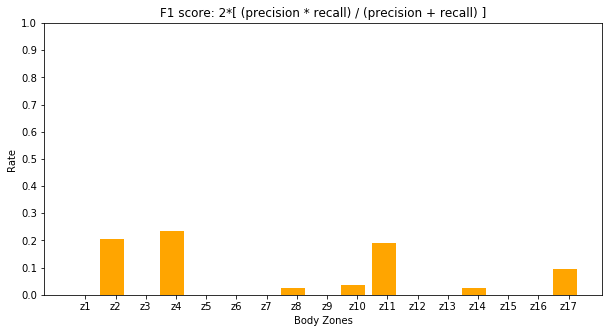

In [43]:
"""
F1 score: 
2*((precision*recall)/(precision+recall)).
"""
f1 = np.zeros(shape=(17), dtype=np.float32)
for ii in range(precision.shape[0]):
    denominator = precision[ii] + recall[ii]
    if denominator > 0:
        f1[ii] = (precision[ii] * recall[ii]) / denominator

plt.rcParams['figure.figsize'] = (10, 5) #width, height
fig, ax = plt.subplots()
width_bars = 0.5
indices = np.arange(17)
ax.bar(indices, f1 , color='orange');
ax.set_title("F1 score: 2*[ (precision * recall) / (precision + recall) ]");
ax.set_ylabel('Rate')
ax.set_xlabel('Body Zones')
ax.set_yticks(np.arange(0,1.01,.1))
ax.set_xticks(indices + width_bars / 4);
ax.set_xticklabels(["z" + str(i) for i in range(1,18,1)]);